In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [3]:
import numpy as np
from events_data import EventsData
from dataset import SCDatasetInfo

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str):
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, bins, ax, **hist_kwargs):
    ax.hist(events.fvt_score[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(events.fvt_score[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(events.fvt_score[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)

In [4]:
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_v1_base.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]


existing_hparams = TSTInfo.get_existing_hparams()
seeds = np.unique([h["seed"] for h in existing_hparams])
signal_ratios = np.unique([h["signal_ratio"] for h in existing_hparams])
n_3bs = np.unique([h["n_3b"] for h in existing_hparams])

  0%|          | 0/17 [00:00<?, ?it/s]

seed: 0, signal_ratio: 0.0
4b, signal in SR:  0.20000298 nan
4b, signal in CR:  0.5999928 nan
FvT p-value: 0.408
FvT rejected: False


/tmp/ipykernel_1142651/3240891381.py:91: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(weights_signal[in_SR]) / np.sum(weights_signal))
/tmp/ipykernel_1142651/3240891381.py:93: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(weights_signal[in_CR]) / np.sum(weights_signal))
/tmp/ipykernel_1142651/3240891381.py:124: RuntimeWarning: invalid value encountered in divide
  ratio_3b_bg4b = hist_3b / hist_bg4b
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),


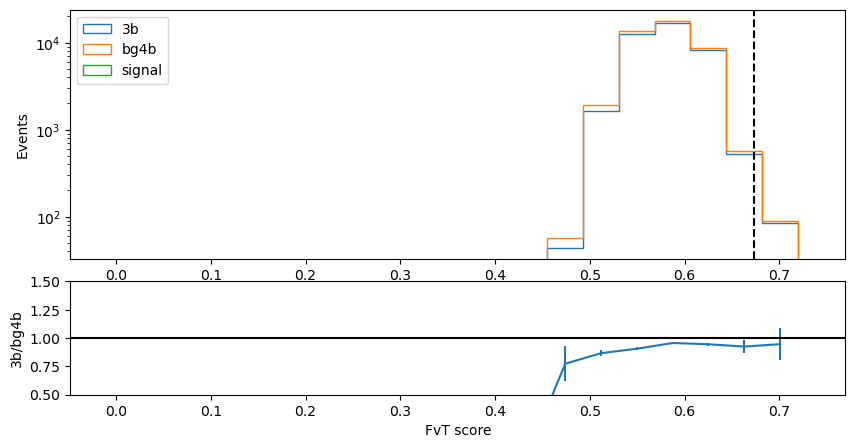

  6%|▌         | 1/17 [00:06<01:43,  6.46s/it]

seed: 0, signal_ratio: 0.01
4b, signal in SR:  0.20000221 0.4395236
4b, signal in CR:  0.5999949 0.49565437
FvT p-value: 1.0
FvT rejected: False


/tmp/ipykernel_1142651/3240891381.py:124: RuntimeWarning: invalid value encountered in divide
  ratio_3b_bg4b = hist_3b / hist_bg4b
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),


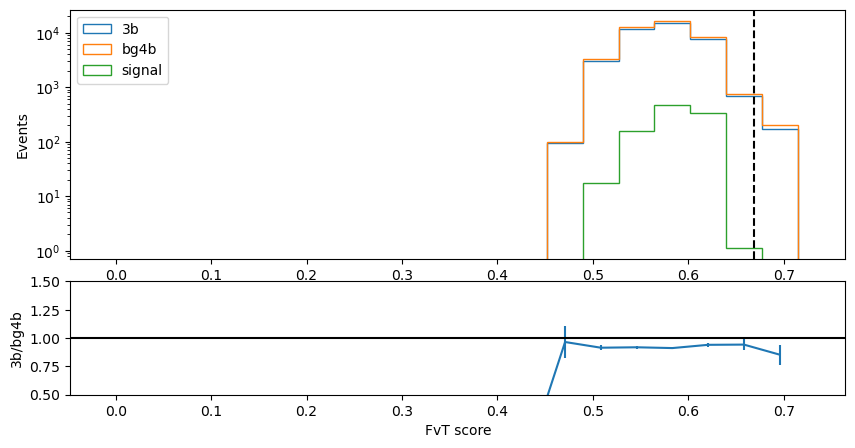

 12%|█▏        | 2/17 [00:13<01:38,  6.59s/it]

seed: 0, signal_ratio: 0.02
4b, signal in SR:  0.20000459 0.82304794
4b, signal in CR:  0.59999585 0.14813815
FvT p-value: 0.0
FvT rejected: True


/tmp/ipykernel_1142651/3240891381.py:124: RuntimeWarning: invalid value encountered in divide
  ratio_3b_bg4b = hist_3b / hist_bg4b
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),


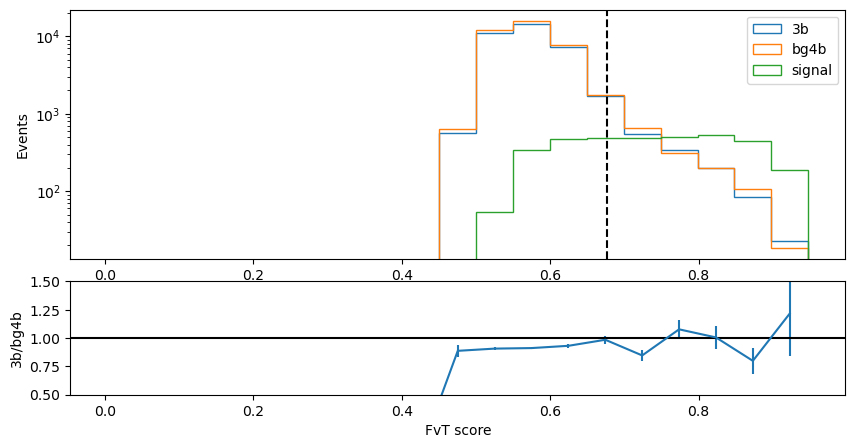

 18%|█▊        | 3/17 [00:20<01:35,  6.86s/it]

seed: 1, signal_ratio: 0.0
4b, signal in SR:  0.2000037 nan
4b, signal in CR:  0.59999317 nan
FvT p-value: 0.494
FvT rejected: False


/tmp/ipykernel_1142651/3240891381.py:91: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(weights_signal[in_SR]) / np.sum(weights_signal))
/tmp/ipykernel_1142651/3240891381.py:93: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(weights_signal[in_CR]) / np.sum(weights_signal))
/tmp/ipykernel_1142651/3240891381.py:124: RuntimeWarning: invalid value encountered in divide
  ratio_3b_bg4b = hist_3b / hist_bg4b
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),


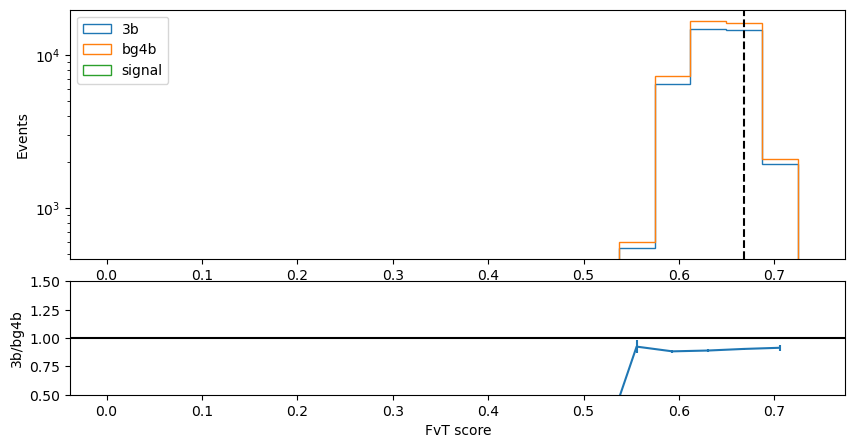

 24%|██▎       | 4/17 [00:27<01:29,  6.88s/it]

seed: 1, signal_ratio: 0.01
4b, signal in SR:  0.2000033 0.52695775
4b, signal in CR:  0.5999979 0.4111194
FvT p-value: 0.854
FvT rejected: False


/tmp/ipykernel_1142651/3240891381.py:124: RuntimeWarning: invalid value encountered in divide
  ratio_3b_bg4b = hist_3b / hist_bg4b
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),


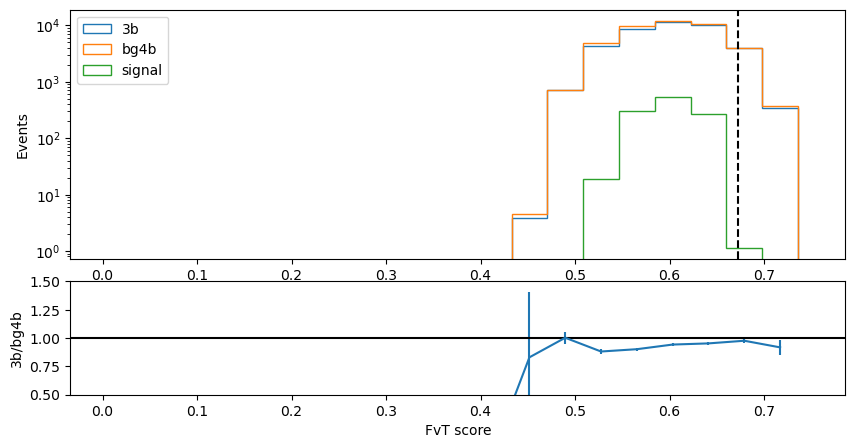

 29%|██▉       | 5/17 [00:33<01:21,  6.80s/it]

seed: 1, signal_ratio: 0.02
4b, signal in SR:  0.20000346 0.75712407
4b, signal in CR:  0.599999 0.19800733
FvT p-value: 0.0
FvT rejected: True


/tmp/ipykernel_1142651/3240891381.py:124: RuntimeWarning: invalid value encountered in divide
  ratio_3b_bg4b = hist_3b / hist_bg4b
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),
/tmp/ipykernel_1142651/3240891381.py:130: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b),


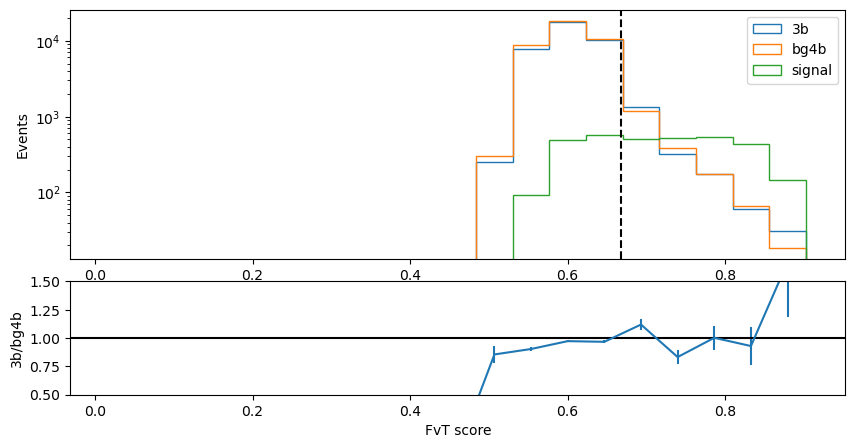

 35%|███▌      | 6/17 [00:47<01:27,  7.98s/it]


ValueError: a must be greater than 0 unless no samples are taken

In [20]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

verbose = True
show_plots = True
hparam_filter = {
    "experiment_name": experiment_name,
    "n_3b": 100_0000,
}

hashes = TSTInfo.find(hparam_filter)
tst_results = []

def permutation_test(stat_fn, is_4b, score, n_shuffles=1000, seed=None, direction="greater"):
    if seed is not None:
        np.random.seed(seed)
    test_statistic = stat_fn(is_4b, score)
    shuffled_test_statistic = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        np.random.shuffle(is_4b)
        shuffled_test_statistic[i] = stat_fn(is_4b, score)
    
    if direction == "greater":
        p_value = np.mean(shuffled_test_statistic > test_statistic)
    elif direction == "less":
        p_value = np.mean(shuffled_test_statistic < test_statistic)
    else:
        raise ValueError(f"Unknown direction: {direction}")
    return p_value

for tstinfo_hash in tqdm.tqdm(hashes):
# for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()


    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

    weights_4b = events_tst.weights * events_tst.is_4b
    weights_signal = events_tst.weights * events_tst.is_signal
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    probs_4b_est = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
    events_tst.reweight(
        np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights))
    events_tst_SR = events_tst[in_SR]

    n_samples = 1000
    # fvt_cut = np.mean(events_tst.fvt_score) + np.std(events_tst.fvt_score)
    # qcuts = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    qcuts = [0.95]
    
    for qcut in qcuts:
        fvt_cut = np.quantile(events_tst.poisson_sample(10 * n_samples, seed=seed).fvt_score, qcut)
        tst_samples = events_tst[in_SR & (events_tst.fvt_score > fvt_cut)].poisson_sample(n_samples, seed=seed)

        is_4b = tst_samples.is_4b
        fvt_score = tst_samples.fvt_score

        def fvt_test_statistic(is_4b, score):
            # return np.abs(np.mean(score[is_4b]) - np.mean(score[~is_4b]))
            return np.mean(score[is_4b]) - np.mean(score[~is_4b])
        def binary_test_statistic(is_4b, score):
            return np.mean(score[is_4b] > fvt_cut)
        
        fvt_p_value = permutation_test(fvt_test_statistic, is_4b, fvt_score, seed=seed, direction="greater")
        # binary_p_value = permutation_test(binary_test_statistic, is_4b, fvt_score, seed=seed, direction="greater")
        
        if verbose:
            print(f"seed: {seed}, signal_ratio: {signal_ratio}")
            print("4b, signal in SR: ", np.sum(weights_4b[in_SR]) / np.sum(weights_4b), 
                np.sum(weights_signal[in_SR]) / np.sum(weights_signal))
            print("4b, signal in CR: ", np.sum(weights_4b[in_CR]) / np.sum(weights_4b),
                    np.sum(weights_signal[in_CR]) / np.sum(weights_signal))

            print(f"FvT p-value: {fvt_p_value}")
            print(f"FvT rejected: {fvt_p_value < 0.05}")
            # print(f"FvT p-value: {fvt_p_value}, binary p-value: {binary_p_value}")
            # print(f"FvT rejected: {fvt_p_value < 0.05}, binary rejected: {binary_p_value < 0.05}")

        if show_plots:
            # bins = np.linspace(0, 1, 30)
            min_score = np.min(events_tst.fvt_score)
            max_score = np.max(events_tst.fvt_score)
            bins = np.linspace(min_score, max_score, 20)
            
            fig = plt.figure(figsize=(10, 5))
            gs = GridSpec(3, 1, figure=fig)
            ax1 = fig.add_subplot(gs[0:2])
            hist_events_by_labels(events_tst_SR, bins, ax1)
            ax1.axvline(fvt_cut, color="black", linestyle="--")
            ax1.set_yscale("log")
            ax1.set_xlim(min_score - 0.05, max_score + 0.05)
            ax1.set_xlabel("FvT score")
            ax1.set_ylabel("Events")
            ax1.legend()

            hist_3b, _ = np.histogram(events_tst_SR.fvt_score[events_tst_SR.is_3b], bins=bins, 
                                    weights=events_tst_SR.weights[events_tst_SR.is_3b])
            hist_bg4b, _ = np.histogram(events_tst_SR.fvt_score[events_tst_SR.is_bg4b], bins=bins, 
                                        weights=events_tst_SR.weights[events_tst_SR.is_bg4b])
            hist_signal, _ = np.histogram(events_tst_SR.fvt_score[events_tst_SR.is_signal], bins=bins, 
                                        weights=events_tst_SR.weights[events_tst_SR.is_signal])

            ratio_3b_bg4b = hist_3b / hist_bg4b
            ratio_3b_bg4b[np.isnan(ratio_3b_bg4b)] = 0
            midpoints = (bins[1:] + bins[:-1]) / 2
            ax2 = fig.add_subplot(gs[2])
            ax2.errorbar(midpoints, 
                        ratio_3b_bg4b, 
                        yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b), 
                        label="3b/bg4b")
            ax2.set_xlabel("FvT score")
            ax2.set_ylabel("3b/bg4b")
            ax2.set_ylim(0.5, 1.5)
            ax2.set_xlim(min_score - 0.05, max_score + 0.05)
            ax2.axhline(1, color="black")
            plt.show()

        tst_results.append({
                "seed": seed,
                "qcut": qcut,
                "signal_ratio": signal_ratio,
                "fvt": {
                    "p_value": fvt_p_value,
                    "rejected": fvt_p_value < 0.05,
                },
                # "binary": {
                #     "p_value": binary_p_value,
                #     "rejected": binary_p_value < 0.05,
                #     "fvt_cut": fvt_cut,
                # }
            })

# tst_results_fvt_df = pd.DataFrame(
# [
#     {
#         "qcut": qcut,
#         "seed": r["seed"],
#         "signal_ratio": r["signal_ratio"],
#         "p_value": r["fvt"]["p_value"],
#         "rejected": r["fvt"]["rejected"],
#     }
#     for r in tst_results
# ]
# )

In [16]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": experiment_name,
    "n_3b": 100_000,
}

hashes = TSTInfo.find(hparam_filter)
tst_results = []

def permutation_test(stat_fn, is_4b, score, n_shuffles=1000, seed=None, direction="greater"):
    if seed is not None:
        np.random.seed(seed)
    test_statistic = stat_fn(is_4b, score)
    shuffled_test_statistic = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        np.random.shuffle(is_4b)
        shuffled_test_statistic[i] = stat_fn(is_4b, score)
    
    if direction == "greater":
        p_value = np.mean(shuffled_test_statistic > test_statistic)
    elif direction == "less":
        p_value = np.mean(shuffled_test_statistic < test_statistic)
    else:
        raise ValueError(f"Unknown direction: {direction}")
    return p_value

for tstinfo_hash in tqdm.tqdm(hashes):
# for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()


    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

    weights_4b = events_tst.weights * events_tst.is_4b
    weights_signal = events_tst.weights * events_tst.is_signal
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    probs_4b_est = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
    events_tst.reweight(
        np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights))
    events_tst_SR = events_tst[in_SR]

    n_samples = 1000
    # fvt_cut = np.mean(events_tst.fvt_score) + np.std(events_tst.fvt_score)
    qcuts = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    
    for qcut in qcuts:
        fvt_cut = np.quantile(events_tst.poisson_sample(10 * n_samples, seed=seed).fvt_score, qcut)
        tst_samples = events_tst[in_SR & (events_tst.fvt_score > fvt_cut)].poisson_sample(n_samples, seed=seed)

        is_4b = tst_samples.is_4b
        fvt_score = tst_samples.fvt_score

        def fvt_test_statistic(is_4b, score):
            # return np.abs(np.mean(score[is_4b]) - np.mean(score[~is_4b]))
            return np.mean(score[is_4b]) - np.mean(score[~is_4b])
        def binary_test_statistic(is_4b, score):
            return np.mean(score[is_4b] > fvt_cut)
        
        fvt_p_value = permutation_test(fvt_test_statistic, is_4b, fvt_score, seed=seed, direction="greater")
        # binary_p_value = permutation_test(binary_test_statistic, is_4b, fvt_score, seed=seed, direction="greater")
        
        if verbose:
            print(f"seed: {seed}, signal_ratio: {signal_ratio}")
            print("4b, signal in SR: ", np.sum(weights_4b[in_SR]) / np.sum(weights_4b), 
                np.sum(weights_signal[in_SR]) / np.sum(weights_signal))
            print("4b, signal in CR: ", np.sum(weights_4b[in_CR]) / np.sum(weights_4b),
                    np.sum(weights_signal[in_CR]) / np.sum(weights_signal))

            print(f"FvT p-value: {fvt_p_value}")
            print(f"FvT rejected: {fvt_p_value < 0.05}")
            # print(f"FvT p-value: {fvt_p_value}, binary p-value: {binary_p_value}")
            # print(f"FvT rejected: {fvt_p_value < 0.05}, binary rejected: {binary_p_value < 0.05}")

        if show_plots:
            # bins = np.linspace(0, 1, 30)
            min_score = np.min(events_tst.fvt_score)
            max_score = np.max(events_tst.fvt_score)
            bins = np.linspace(min_score, max_score, 20)
            
            fig = plt.figure(figsize=(10, 5))
            gs = GridSpec(3, 1, figure=fig)
            ax1 = fig.add_subplot(gs[0:2])
            hist_events_by_labels(events_tst_SR, bins, ax1)
            ax1.axvline(fvt_cut, color="black", linestyle="--")
            ax1.set_yscale("log")
            ax1.set_xlim(min_score - 0.05, max_score + 0.05)
            ax1.set_xlabel("FvT score")
            ax1.set_ylabel("Events")
            ax1.legend()

            hist_3b, _ = np.histogram(events_tst_SR.fvt_score[events_tst_SR.is_3b], bins=bins, 
                                    weights=events_tst_SR.weights[events_tst_SR.is_3b])
            hist_bg4b, _ = np.histogram(events_tst_SR.fvt_score[events_tst_SR.is_bg4b], bins=bins, 
                                        weights=events_tst_SR.weights[events_tst_SR.is_bg4b])
            hist_signal, _ = np.histogram(events_tst_SR.fvt_score[events_tst_SR.is_signal], bins=bins, 
                                        weights=events_tst_SR.weights[events_tst_SR.is_signal])

            ratio_3b_bg4b = hist_3b / hist_bg4b
            ratio_3b_bg4b[np.isnan(ratio_3b_bg4b)] = 0
            midpoints = (bins[1:] + bins[:-1]) / 2
            ax2 = fig.add_subplot(gs[2])
            ax2.errorbar(midpoints, 
                        ratio_3b_bg4b, 
                        yerr=np.sqrt(1 / hist_3b + 1 / hist_bg4b) * (hist_3b / hist_bg4b), 
                        label="3b/bg4b")
            ax2.set_xlabel("FvT score")
            ax2.set_ylabel("3b/bg4b")
            ax2.set_ylim(0.5, 1.5)
            ax2.set_xlim(min_score - 0.05, max_score + 0.05)
            ax2.axhline(1, color="black")
            plt.show()

        tst_results.append({
                "seed": seed,
                "qcut": qcut,
                "signal_ratio": signal_ratio,
                "fvt": {
                    "p_value": fvt_p_value,
                    "rejected": fvt_p_value < 0.05,
                },
                # "binary": {
                #     "p_value": binary_p_value,
                #     "rejected": binary_p_value < 0.05,
                #     "fvt_cut": fvt_cut,
                # }
            })

# tst_results_fvt_df = pd.DataFrame(
# [
#     {
#         "qcut": qcut,
#         "seed": r["seed"],
#         "signal_ratio": r["signal_ratio"],
#         "p_value": r["fvt"]["p_value"],
#         "rejected": r["fvt"]["rejected"],
#     }
#     for r in tst_results
# ]
# )

100%|██████████| 242/242 [08:30<00:00,  2.11s/it]


In [13]:
tst_results_fvt_df.to_csv(f"tst_results_{experiment_name}_fvt.csv", index=False)

In [15]:
tst_results_fvt_df.groupby(["signal_ratio", "qcut"]).agg(
    {
        "p_value": ["mean", "std"],
        "rejected": ["mean"],
    }
)

p_value            rejected
                       mean       std      mean
signal_ratio qcut                              
0.00         0.95  0.395538  0.330202  0.170940
0.01         0.95  0.454299  0.326139  0.141026
0.02         0.95  0.429530  0.320443  0.136752
0.03         0.95  0.416744  0.314387  0.145299
0.04         0.95  0.318393  0.353807  0.397436
0.05         0.95  0.166957  0.271599  0.611111

In [7]:
tst_results_fvt_df = pd.DataFrame(
    [
        {
            "qcut": r["qcut"],
            "seed": r["seed"],
            "signal_ratio": r["signal_ratio"],
            "p_value": r["fvt"]["p_value"],
            "rejected": r["fvt"]["rejected"],
        }
        for r in tst_results
    ]
)

# tst_results_binary_df = pd.DataFrame(
#     [
#         {
#             "seed": r["seed"],
#             "signal_ratio": r["signal_ratio"],
#             "p_value": r["binary"]["p_value"],
#             "rejected": r["binary"]["rejected"],
#         }
#         for r in tst_results
#     ]
# )

KeyError: 'qcut'

In [12]:
tst_results_fvt_df.groupby(["signal_ratio", "qcut"]).agg(
    {
        "p_value": ["mean", "std"],
        "rejected": ["mean"],
    }
)

KeyError: 'qcut'